# Import Libraries

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from PyEMD import CEEMDAN
from vmdpy import VMD
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform


numpy and pandas: Used for data manipulation.

matplotlib.pyplot: For plotting data.

PyEMD: Provides CEEMDAN decomposition, an advanced signal processing technique.

vmdpy: Used for Variational Mode Decomposition (VMD).

sklearn: Metrics and preprocessing for scaling data and calculating performance metrics.

tensorflow.keras: For defining and training LSTM neural network models.

# Loading Dataset

In [68]:
data = pd.read_csv('data3.csv')


 Load the dataset, assuming the file data3.csv contains the time series data for forecasting

# Preprocessing the Data

In [69]:
raw_data = data.drop(columns='year').values.flatten()

Drop the year column and reshape the remaining data into a 1D array (raw_data) for analysis, making it easier to handle for the decompositions.

In [70]:
train_size = int(len(raw_data) * 0.8)
train, test = raw_data[:train_size], raw_data[train_size:]

# Data Normalization

In [71]:
scaler = MinMaxScaler()
train = train.reshape(-1, 1)
train_scaled = scaler.fit_transform(train).flatten()

Normalize the training data using MinMaxScaler, which scales the data between 0 and 1. This is necessary for LSTM models, which perform better with scaled data. The .flatten() method ensures the scaled data is reshaped back into a 1D array.


In [72]:
test = test.reshape(-1, 1)
test_scaled = scaler.transform(test).flatten()


Normalize the test data using the same scaler, ensuring the model uses consistent scaling.

# CEEMDAN Decomposition

In [73]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [74]:
ceemdan = CEEMDAN(noise_strength=0.4, ensemble_size=220, max_sift_iterations=140, sifting_tolerance=0.3, max_imfs=7, adaptive_noise=True)
ceemdan_imfs_train = ceemdan.ceemdan(train_scaled)


 Perform CEEMDAN decomposition on the scaled training data, which breaks the data into multiple Intrinsic Mode Functions (IMFs). CEEMDAN is a noise-assisted data decomposition method that helps analyze non-stationary time series data.

In [75]:
ceemdan_imfs_train = ceemdan_imfs_train[:4]


Keep only the first 4 IMFs, which usually capture the most significant components of the time series data.

#  Plotting IMFs

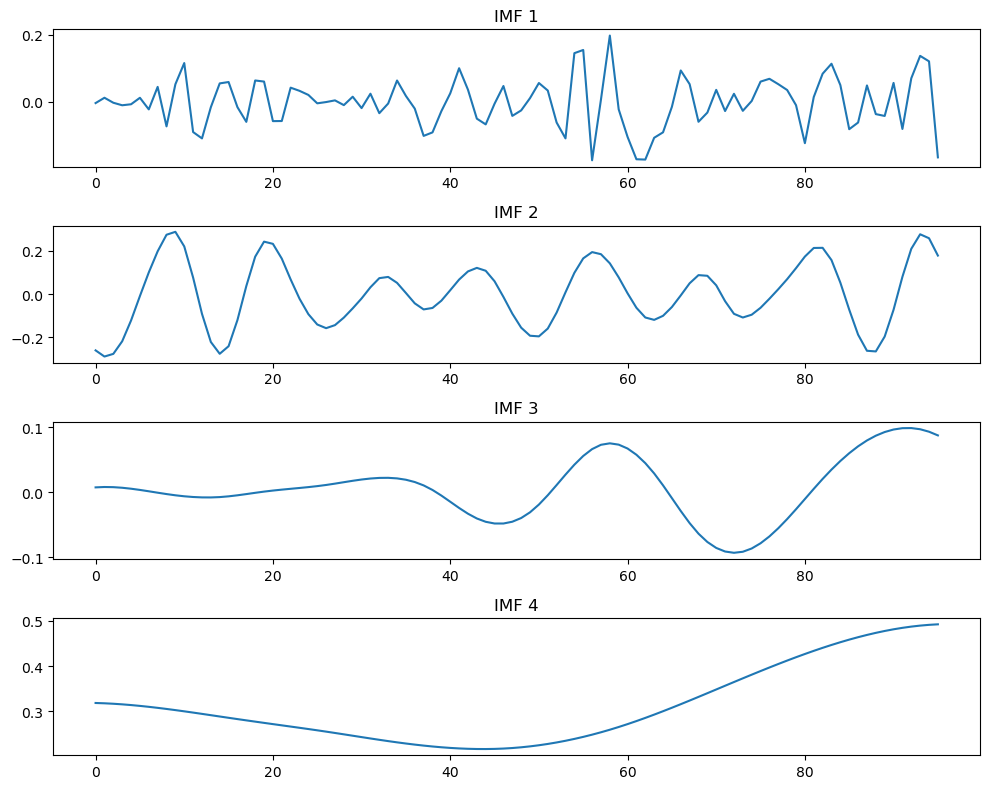

In [76]:
plt.figure(figsize=(10, 8))
for i, imf in enumerate(ceemdan_imfs_train):
    plt.subplot(len(ceemdan_imfs_train), 1, i + 1)
    plt.plot(imf)
    plt.title(f'IMF {i + 1}')
plt.tight_layout()
plt.show()


# VMD Decomposition

In [77]:
def vmd_decomposition(data, alpha=1900, max_iter=1000, tau=0.8, K=3, DC=2, init=3, tol=2e-3):
    u, u_hat, omega = VMD(data, alpha=alpha, tau=tau, K=K, DC=DC, init=init, tol=tol)
    return u


Define a function that applies VMD decomposition to the CEEMDAN IMFs. VMD is a mode decomposition technique that extracts oscillatory modes from a signal.

In [78]:
all_vmd_outputs = []
for imf in ceemdan_imfs_train:
    vmd_outputs = vmd_decomposition(imf)
    all_vmd_outputs.append(vmd_outputs)


Apply VMD to each IMF and store the resulting modes in all_vmd_outputs.

# Create Sequences for LSTM

In [79]:
def create_sequences(data, n_steps):
    sequences = []
    for i in range(len(data) - n_steps+1):
        sequences.append(data[i:i + n_steps])
    return np.array(sequences)


Define a function to create sequences from the VMD outputs. LSTMs require data to be formatted as sequences of time steps to learn the temporal patterns.

In [80]:
n_steps=13
combined_sequences = []
for vmd_output in all_vmd_outputs:
    for output in vmd_output:
        sequences = create_sequences(output, n_steps)
        combined_sequences.append(sequences)
combined_sequences = np.concatenate(combined_sequences, axis=0)


Create sequences from all the VMD outputs and combine them into one array for LSTM training.

In [81]:
combined_sequences_reshaped = combined_sequences.reshape((-1, n_steps, 1))

# LSTM Model Definition and Training

In [82]:
def lstm_model(n_steps):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, 1), kernel_initializer=GlorotUniform(seed=42)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu', kernel_initializer=GlorotUniform()))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer=GlorotUniform()))
    model.compile(optimizer='nadam', loss='log_cosh')
    return model


Define an LSTM model with two LSTM layers, each followed by a Dropout layer to prevent overfitting. The weight initializer used is GlorotUniform. The loss function is log_cosh, which is smooth and works well for regression problems.

In [83]:
y_train = combined_sequences[:, -1]
lstm = lstm_model(n_steps)
lstm.fit(combined_sequences_reshaped, y_train, epochs=100, verbose=1,shuffle=False)


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.0035
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0032
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0028
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0027
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0031
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0030
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0026
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0025
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0024
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - l

Extract the target values for training and fit the LSTM model on the training sequence

# Testing and Evaluation


In [84]:
test_sequences = create_sequences(test_scaled, n_steps)
test_sequences_reshaped = test_sequences.reshape((test_sequences.shape[0], n_steps, 1))
lstm_pred = lstm.predict(test_sequences_reshaped)
y_true = test_sequences[:, -1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 Create sequences from the test data, predict using the LSTM model, and store the true values for evaluation.

In [85]:
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
y_true_rescaled = scaler.inverse_transform(y_true.reshape(-1, 1))


Reverse the scaling of the predictions and true values to their original scale

# Metrics Calculation

In [86]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mad = np.mean(np.abs(y_true - y_pred))
    me = np.mean(y_true - y_pred)
    return rmse, mape, mad, me

rmse, mape, mad, me = calculate_metrics(y_true_rescaled.flatten(), lstm_pred_rescaled.flatten())


Calculate key performance metrics: RMSE, MAPE, MAD, and ME.

In [87]:
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"MAD: {mad}")
print(f"ME: {me}")


RMSE: 9.141553395589856
MAPE: 3.264606056837672%
MAD: 7.306853993733722
ME: 3.417377471923826


#  Plotting Results

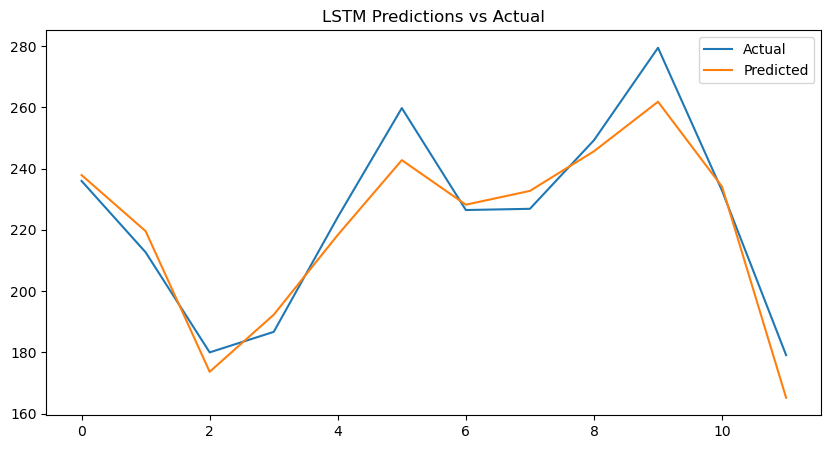

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(y_true_rescaled, label='Actual')
plt.plot(lstm_pred_rescaled, label='Predicted')
plt.legend()
plt.title('LSTM Predictions vs Actual')
plt.show()
